# Refactoring do Notebook de Momemtum

O objetivo deste notebook é tornar a implementação do TSMOM modular e reutilizável.
Analisemos o código original do TSMOM:

```python
# Calcula retorno do tsmom no período de um mês
def tsmom (paramters, date, vol="ewma", method = 'momentum', risk=0.4, passive=False):
    """
    Simula a estrátegia de investimento em um período, retorna a rentabilidade no período simulado.
    """
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = paramters
    
    # vol means volatility and not volume 
    vol_monthly = []
    
    # Escolhe qual estratégia de cálculo de volatilidade utilizar na estratégia
    if vol == "ewma":
        vol_monthly = ewma_vol
    elif vol == "parkinson":
        vol_monthly = pv_monthly
    elif vol == "garman_klass":
        vol_monthly = gk_monthly
    else:
        raise NameError('Volatilidade invalida')
    
    # Com base na estratégia selecionada (variável "method"), calcula os sinais para cada um dos ativos 
    positions = signal(paramters, date, passive, method)
    
    Last_Month = date - 1  # Mês cujos dados serão utilizados para calcular os parâmetros da estratégia
    Actual_Month = date  # Mês em que a estratégia será simulada
    
    weights = (risk / vol_monthly.iloc[Last_Month])  
    normalized_weights = weights / len(weights)  
    portfolio = positions * normalized_weights # Calcula os pesos de cada ativo no portfolio da estratégia
    
    period_return = 1 + np.dot(portfolio, returns_monthly.iloc[Actual_Month])
    return period_return  # Retorna qual seria o retorno caso a estratégia tivesse sido aplicada no mês Actual_Month
```


O algoritmo executa as seguintes etapas:

1. Calcula a volatilidade de cada período (no caso acima, o período é sempre 1 mês)
1. Com base na volatilidade e no período de cada mês, calcula o sinal para cada ativo utilizando alguma estratégia
1. Calcula a alocação de cada ativo deve ter no portfólio com base nas volatilidades de cada um
1. Com os pesos e o sinal de cada ativo, calcula a rentabilidade que teria no mês

Uma análise do código revela que existem diferentes estratégias que podem ser utilizadas para calcular a volatilidade, bem como existem diferentes maneiras de calcular os sinais de cada ativo. Assim, podemos simular diferentes TSMOMs, a depender da estratégia de cálculo de volatilidade e sinais que escolhermos. Podemos aplicar o [Padrão Estratégia](https://refactoring.guru/design-patterns/strategy) para deixar o código mais flexível e simplificar essa escolha.

Além disso, como insumo para o cálculo do TSMOM são necessários os dados históricos dos ativos que compõem o portfolio. Podemos portanto esquematizá-lo da seguinte maneira:



* TSMOM:
    * Parâmetros
        * Estratégia de cálculo de Volatilidade
        * Estratégia de cálculo de Sinais
        * Dados históricos dos ativos que compõem o portfolio
        * Risco
    * Etapas
        * Define como calcular volatilidade e sinais
        * Utiliza parâmetros para gerar sinais e alocações
        * Simula retorno da estratégia em um dado mês
        

In [2]:
import time
import pandas as pd
import numpy as np
from typing import Iterable, Optional
import yfinance as yf
import datetime
import matplotlib.pyplot as plt


# Decorador para cronometrar tempo de execução
# Não deve ser utilizado em funções recursivas
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        execution_time = end_time - start_time
        print(f"Function '{func.__name__}' took {execution_time:.6f} seconds to execute.")
        return result
    return wrapper

## Abstração dos parâmetros

In [3]:
class Params:
    def __init__(self, tickers: Iterable[str], start_date: str, end_date: str) -> None:
        self.df = yf.download(tickers, start=start_date, end=end_date)
        self.df.index = pd.to_datetime(self.df.index)
        self.tickers : pd.DataFrame = tickers
        self.start_date : pd.DataFrame = start_date
        self.end_date : pd.DataFrame = end_date
        self.adj_close : pd.DataFrame = self.df['Adj Close']
        self.close : pd.DataFrame = self.df['Close']
        self.high : pd.DataFrame = self.df['High']
        self.low : pd.DataFrame = self.df['Low']
        self.open : pd.DataFrame = self.df['Open']
        self.volume : pd.DataFrame = self.df['Volume']
        self.returns_daily = self.close.pct_change().fillna(0)  # Retornos diários
        self.returns_monthly = self.close.pct_change(20).fillna(0).resample('BM').last().ffill()  # Retornos mensais


## Abstração da Volatilidade

In [4]:
class VolatilityStrategy:
    def compute(self, params: Params, period=60) -> pd.DataFrame:
        pass

class ParkinsonVolatility(VolatilityStrategy):
    def compute(self, params: Params, period=60) -> pd.DataFrame:
        """
        Estimando a volatilidade a partir dos preço de Alta e de Baixa
        """

        DAYS_IN_MARKET_YEAR = 261
        
        log_ratio = np.log(np.divide(params.high, params.low)) ** 2  # Calculando parcela interna da somatoria
        parkinson_vol = log_ratio.copy()  # Criando dataframe para atribuir as volatilidades
        
        
        Period_Const = 1 / (4 * period * np.log(2))  # Termo constante fora da somatoria (Considerando vol diaria)
        parkinson_vol.iloc[:period,:] = np.nan  # Atribuindo not a number, para os valores iniciais

        for row in range(period, len(params.high)): # iteração do centro de massa da vol
            parkinson_vol.iloc[row] = np.sqrt(Period_Const * np.sum(log_ratio.iloc[row-period:row,:]))
            
        return (np.sqrt(DAYS_IN_MARKET_YEAR)*parkinson_vol).resample('BM').last().ffill()


# TODO: Implementar mais volatilidades

## Abstração do Sinal

In [5]:
class SignalStrategy:
    def compute(self, params: Params, month:str) -> np.ndarray:
        pass

class PassiveSignal(SignalStrategy):
    def compute(self, params: Params, month:Optional[str]) -> np.ndarray:
        # Sempre compra
        num_assets = len(params.close.columns)
        return np.ones(num_assets)
    
class MomentumSignal(SignalStrategy):
    def compute(self, params: Params, month:str) -> np.ndarray:
        returns = params.close.pct_change(21 * 12).resample('BM').last().ffill()
        return np.where(returns.iloc[-1] > 0, 1, -1)
    
# TODO: implementar mais sinais
        

## TSMOM

In [12]:
class TimeSeriesMomentum:
    """
        Calcula o TSMOM para um determinado mês
    """
    def __init__(self, signal: SignalStrategy, volatility: VolatilityStrategy, risk) -> None:
        self.signal = signal
        self.volatility = volatility
        self.risk = risk

    def compute(self, params: Params, month: str) -> float:
        """
            Calcula o retorno do TSMOM em um determinado mês
        """
        last_month = self._compute_last_month(month)
        
        signal = self.signal.compute(params, month)  # um sinal para cada ativo
        volatility = self.volatility.compute(params)  # uma volatilidade por mês
        
        weights = (self.risk / volatility.loc[last_month])

        normalized_weights = weights / len(weights.T) # por que divide pelo tamanho e nao pela soma?


        portfolio = (signal * normalized_weights).to_numpy()
        period_return = 1 + np.dot(portfolio, params.returns_monthly.loc[month].to_numpy().T)
        
        return period_return[0][0]
    
    def _compute_last_month(self, month: str) -> str:
        """
            Helper function to compute last month
        """
        input_date = datetime.datetime.strptime(month, '%Y-%m')
        last_month = input_date - datetime.timedelta(days=input_date.day)
        last_month_string = last_month.strftime('%Y-%m')

        return last_month_string


    def backtest(self, start_date=None, end_date=None):
        # TODO
        pass


## Testando

## Gera portfolios de teste

In [7]:
start_date = '2015-01-01'
end_date = '2022-01-01'

tickers = [
    'ABEV3.SA',  # Ambev S.A.
    'BBAS3.SA',  # Banco do Brasil S.A.
    'BBDC4.SA',  # Banco Bradesco S.A.
    'BBSE3.SA',  # BB Seguridade Participacoes S.A.
    'B3SA3.SA',  # B3 S.A. - Brasil, Bolsa, Balcão
    'BRFS3.SA',  # BRF S.A.
    'BRKM5.SA',  # Braskem S.A.
    'CCRO3.SA',  # CCR S.A.
    'CIEL3.SA',  # Cielo S.A.
    'CMIG4.SA',  # Cemig - Companhia Energetica de Minas Gerais
    'CPFE3.SA',  # CPFL Energia S.A.
    'CSAN3.SA',  # Cosan S.A. Industria e Comercio
    'CSNA3.SA',  # Companhia Siderurgica Nacional
    'CYRE3.SA',  # Cyrela Brazil Realty S.A. Empreendimentos e Participacoes
    'ECOR3.SA',  # Ecorodovias Infraestrutura e Logistica S.A.
    'EGIE3.SA',  # Engie Brasil Energia S.A.
    'EMBR3.SA',  # Embraer S.A.
    'ENBR3.SA',  # EDP - Energias do Brasil S.A.
    'EQTL3.SA',  # Equatorial Energia S.A.
    'FLRY3.SA',  # Fleury S.A.
    'GGBR4.SA',  # Gerdau S.A.
    'GOAU4.SA',  # Gerdau S.A.
    'HYPE3.SA',  # Hypera S.A.
    'ITSA4.SA',  # Itausa - Investimentos Itau S.A.
    'ITUB4.SA',  # Itau Unibanco Holding S.A.
    'JBSS3.SA',  # JBS S.A.
    'KLBN11.SA',  # Klabin S.A.
    'LREN3.SA',  # Lojas Renner S.A.
    'MGLU3.SA',  # Magazine Luiza S.A.
    'MRFG3.SA',  # Marfrig Global Foods S.A.
    'PETR3.SA',  # Petroleo Brasileiro S.A. - Petrobras
    'PETR4.SA',  # Petroleo Brasileiro S.A. - Petrobras
    'QUAL3.SA',  # Qualicorp Consultoria e Corretora de Seguros S.A.
    'RADL3.SA',  # Raia Drogasil S.A.
    'RENT3.SA',  # Localiza Rent a Car S.A.
    'SANB11.SA',  # Banco Santander (Brasil) S.A.
    'SBSP3.SA',  # Companhia de Saneamento Basico do Estado de Sao Paulo - SABESP
    'SUZB3.SA',  # Suzano Papel e Celulose S.A.
    'TAEE11.SA',  # Taesa - Transmissora Alianca de Energia Eletrica S.A.
    'TIMS3.SA',  # TIM Participacoes S.A.
    'UGPA3.SA',  # Ultrapar Participacoes S.A.
    'USIM5.SA',  # Usinas Siderurgicas de Minas Gerais S.A. - Usiminas
    'VALE3.SA',  # Vale S.A.
    'VIVT3.SA',  # Telefonica Brasil S.A.
    'WEGE3.SA',  # WEG S.A.
]

portfolio_6= Params(tickers[:6], start_date, end_date)
portfolio_12 = Params(tickers[:12], start_date, end_date)
portfolio_grande = Params(tickers, start_date, end_date)

portfolios = [portfolio_6, portfolio_12, portfolio_grande]

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  45 of 45 completed


In [18]:

tsmom_passive = TimeSeriesMomentum(
    signal=PassiveSignal(),
    volatility=ParkinsonVolatility(),
    risk=0.4
)

tsmom_momentum = TimeSeriesMomentum(
    signal=MomentumSignal(),  # Usa o momentum para calcular os sinais
    volatility=ParkinsonVolatility(),
    risk=0.4
)


@timer
def test_tsmom(tsmom: TimeSeriesMomentum, portfolio: Params, month: str):
    print(f"Usando {len(portfolio.tickers)} ativos")
    returns = tsmom.compute(portfolio, month)

    print(f"O retorno no mês {month} seria {returns}")

test_tsmom(tsmom_passive, portfolio_grande, '2021-09')
test_tsmom(tsmom_momentum, portfolio_grande, '2021-09')



Usando 45 ativos
O retorno no mês 2021-09 seria 0.9350656162780653
Function 'test_tsmom' took 123.971791 seconds to execute.
Usando 45 ativos
O retorno no mês 2021-09 seria 1.0650791025265556
Function 'test_tsmom' took 28.231976 seconds to execute.


# Esses resultados fazem sentido? Parece que não

In [11]:

meses = portfolio_6.df.index.copy().strftime('%Y-%m').unique().to_list()[2:-2]
retornos = [tsmom_momentum.compute(portfolio_6, mes) for mes in meses]

            ABEV3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  BBSE3.SA  BRFS3.SA
Date                                                                  
2015-02-27       NaN       NaN       NaN       NaN       NaN       NaN
ABEV3.SA    False
B3SA3.SA    False
BBAS3.SA    False
BBDC4.SA    False
BBSE3.SA    False
BRFS3.SA    False
Name: 2015-02-27 00:00:00, dtype: bool
            ABEV3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  BBSE3.SA  BRFS3.SA
Date                                                                  
2015-03-31  1.609533   1.07897  1.012537  1.280122   1.11456  1.514169
ABEV3.SA    True
B3SA3.SA    True
BBAS3.SA    True
BBDC4.SA    True
BBSE3.SA    True
BRFS3.SA    True
Name: 2015-03-31 00:00:00, dtype: bool
            ABEV3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  BBSE3.SA  BRFS3.SA
Date                                                                  
2015-04-30  1.816824   1.16112  1.009746  1.437825  1.158913  1.806857
ABEV3.SA    True
B3SA3.SA    True
BBAS3.SA    True
BBDC4.SA    True
BBSE3

           0
0        NaN
1   0.500730
2   1.543669
3   0.885028
4   1.542615
..       ...
75  1.405522
76  1.352806
77  1.549323
78  1.662030
79  0.631748

[80 rows x 1 columns]
TSMOM  return: -100.00%, Annualized: -85.08%


/tmp/ipykernel_21886/3816941171.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tsmom_return = float((returns_df.cumprod().iloc[-1] - 1)*100)


,0
0,NaN
1,5.007301e-01
2,7.729614e-01
3,6.840928e-01
4,1.055292e+00
...,...
75,7.496127e-07
76,1.014081e-06
77,1.571139e-06
78,2.611280e-06


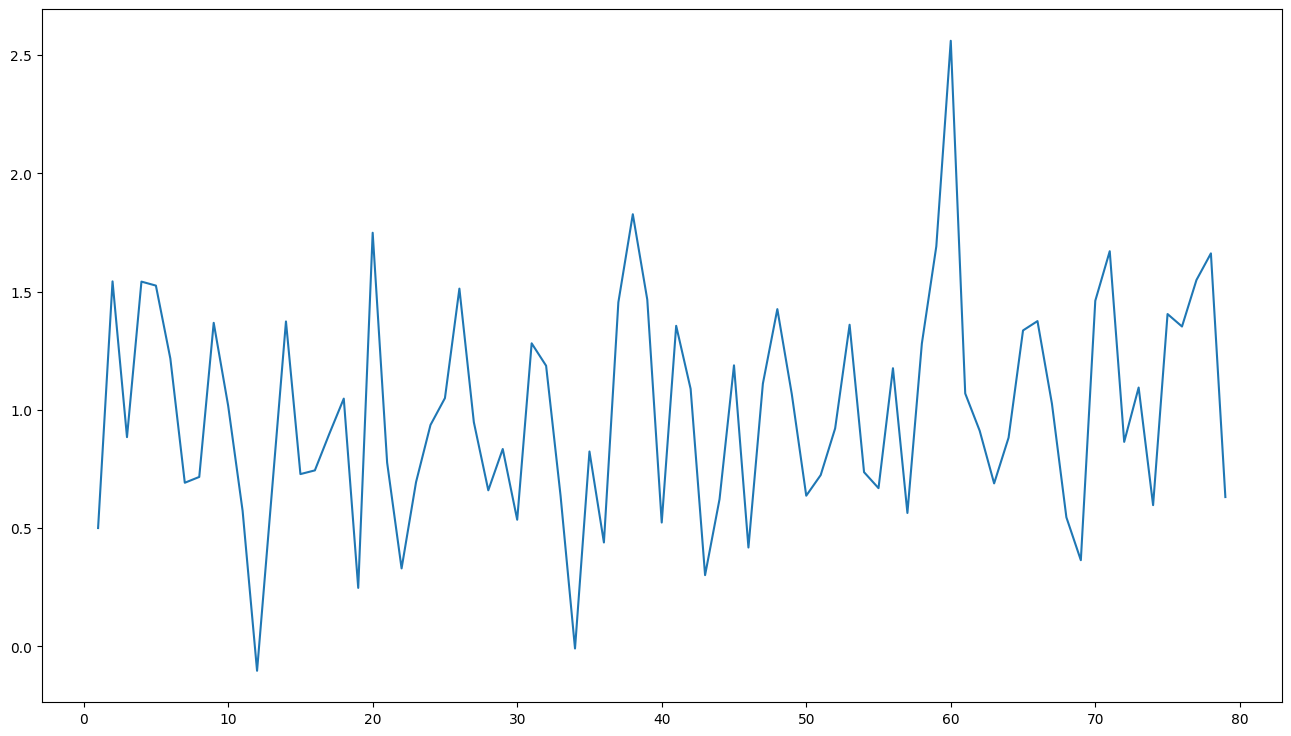

In [17]:

returns_df = pd.DataFrame(retornos)

plt.figure(figsize=(16, 9))

print(returns_df)
plt.plot(returns_df)
years = 7
tsmom_return = float((returns_df.cumprod().iloc[-1] - 1)*100)
print(f'TSMOM  return: {tsmom_return:.2f}%,',
f" Annualized: {(((100+tsmom_return)/100) ** (1/years) - 1)*100:.2f}%", sep='')

returns_df.cumprod()

## TODO:

1. Analisar e testar: código faz sentido?
1. Resultados fazem sentido?
1. Implementar mais estratégias de cálculo de sinais e volatilidade
1. Testar desempenho e otimizar
1. Implementar backtesting
1. Entender melhor o parâmetro risk do TSMOM e como calculá-lo